In [1]:
import polars as pl
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix
os.chdir(os.path.expanduser('~/vivarium-ecoli'))


In [42]:
def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()


Cmatrix = read_matrix("notebooks/mia notebooks/C_matrix.csv", sparse=True)
complex_ids = list(read_names("notebooks/mia notebooks/complex_ids.txt"))
monomer_ids = list(read_names("notebooks/mia notebooks/monomer_ids.txt"))
# Ecocyc data (https://ecocyc.org/groups?tab=SPECIAL&orgid=ECOLI): 
ecocyc_data = pd.read_excel("notebooks/mia notebooks/All_polypeptides_from_ecocyc_data.xlsx")
# validation data (https://www.sciencedirect.com/science/article/pii/S0092867414002323?via%3Dihub#app1):
validation_data = pd.read_excel("notebooks/mia notebooks/data_from_li_et_al_2014.xlsx")

## Minimal Media Conditions Comparison of simulation data with data from Li et al., 2014 

In [3]:
time = '1300'
date = '2024-04-29'
experiment = 'validation_experiment'
entry = f'{experiment}_{time}_{date}'
folder = f'out/cofactors/{entry}/'

In [4]:
output_all = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output_all['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pl.DataFrame(output['bulk'])

fluxes = np.array(fba['estimated_fluxes'][1:])
exchanges = fba['estimated_exchange_dmdt']

ans = output['listeners']['unique_molecule_counts']['active_ribosome']

In [5]:
# So say I want to find the names of the proteins themselves, these are functions to implement that do so: 
initial_state = json.load(open('data/wcecoli_t0.json'))

bulk_ids = [item[0] for item in initial_state['bulk']]

bulk.columns = bulk_ids

In [6]:
# take the protein [location] out of the name of the bulk ids: 
ecocyc_ids = []
for id in bulk_ids: 
	ecocyc_ids.append(id[0:-3])

ecocyc_id_idxs = []
for i in range(len(ecocyc_ids)):
	ecocyc_id_idxs.append(i)

In [7]:
# combine the protein counts for each monomer: 
id_idx_dict = {id: i for i, id in enumerate(bulk_ids)}
idx_id_dict = {idx: i for i, idx in id_idx_dict.items()}

protein_ids = complex_ids + monomer_ids
all_names = []
name_groups = []
idx_groups = []

for p in protein_ids:
	if p not in all_names:
		indexes = [name for key, name in id_idx_dict.items() if p in key]
		for idx in indexes:
			if ecocyc_ids[idx] == p:
				pass
			else:
				indexes.remove(idx)
		name_group = [idx_id_dict.get(name) for name in indexes]
		all_names.append(p)
		name_groups.append([name_group])
		idx_groups.append([indexes])

In [8]:
# fuse and collect protein counts of interest for minimal media (mm) in the C matrix: 
mm_bulk_interest_protein_counts = np.zeros([bulk.shape[0], len(protein_ids)])
mm_bulk_PC_dict = {}

for i in range(len(idx_groups)):
	id = protein_ids[i]
	idxs = idx_groups[i]
	if id in ecocyc_ids:
		if len(idxs) == 1:
			idx = idxs[0][0]
			df = np.array(bulk.select(bulk_ids[idx]))
		else:
			together = []
			for idx in idxs:
				index = idx[0]
				temp_df = np.array(bulk.select(bulk_ids[index]))
				together.append(temp_df)
			df = np.sum(together, axis=1)
		protein_counts = np.transpose(df)
		mm_bulk_interest_protein_counts[:, i] = protein_counts
		mm_bulk_PC_dict.update({id:idxs}) 

In [9]:
# Generate the minimal media data results:
mm_sim_protein_counts = mm_bulk_interest_protein_counts @ Cmatrix

# simplify the results accordingly with the time steps: 
mm_avg_sim_data = mm_sim_protein_counts.mean(axis=0)
# TODO: edit this to account for cell age

In [10]:
# Data from Ecocyc (https://ecocyc.org/groups?tab=SPECIAL&orgid=ECOLI): 
EC_proteins = ecocyc_data.Proteins
EC_genes = ecocyc_data.Genes
EC_gene_CNs = ecocyc_data['Common-Name']

# organize Ecocyc protein name and gene name data: 
EC_id_idx_dict = {id: i for i, id in enumerate(EC_proteins)}
EC_idx_id_dict = {idx: i for i, idx in EC_id_idx_dict.items()}

EC_Gene_idx_dict = {id: i for i, id in enumerate(EC_gene_CNs)}
EC_idx_Gene_dict = {idx: i for i, idx in EC_Gene_idx_dict.items()}

In [11]:
# find the gene name for each monomer in the bulk data using Ecocyc data: 
mm_BD_gene_ids = []
mm_monomers_not_in_EC = []
mm_monomer_idxs_in_EC = []
gene = 1
for i in range(len(monomer_ids)):
	if gene not in mm_BD_gene_ids: 
		monomer = monomer_ids[i]
		monomer_idx = [name for key, name in EC_id_idx_dict.items() if monomer in key]
		if len(monomer_idx) == 0:
			mm_monomers_not_in_EC.append(monomer)
		else: 
			monomer_idx = monomer_idx[0]
			gene = EC_idx_Gene_dict.get(monomer_idx)
			mm_BD_gene_ids.append([gene])
			mm_monomer_idxs_in_EC.append(i)
			
len(mm_BD_gene_ids)

4321

In [12]:
# validation data sets from Li et al., 2014 (https://www.sciencedirect.com/science/article/pii/S0092867414002323?via%3Dihub#app1):
validation_genes = validation_data.Gene
validation_MOPS_data = validation_data['MOPS complete']
validation_MOPS_min = validation_data['MOPS minimal']
validation_MOPS_wo_M = validation_data['MOPS complete without methionine']

# organize validation genes:
V_gene_idx_dict = {id: i for i, id in enumerate(validation_genes)}
V_idx_gene_dict = {idx: i for i, idx in V_gene_idx_dict.items()}

In [13]:
# test out loading in the data from Ecocyc (https://ecocyc.org/groups?tab=SPECIAL&orgid=ECOLI) using the polars methods: 
test_df = pl.read_csv("notebooks/mia notebooks/test_name_df.csv", separator="\t", truncate_ragged_lines=True)
test_df

Proteins,Genes,Accession-1 of Gene,Common-Name
str,str,str,str
"""LYSU-CPLX""","""EG10553""","""b4129""","""lysU"""
"""EG11817-MONOME…","""EG11817""","""b2744""","""umpG"""
"""MONOMER0-4534""","""G6577""","""b1120""","""cobB"""
"""FDOI-MONOMER""","""EG11856""","""b3892""","""fdoI"""
"""G6991-MONOMER""","""G6991""","""b1807""","""tsaB"""
…,…,…,…
"""G7835-MONOMER""","""G7835""","""b4145""","""yjeJ"""
"""GALACTITOLPDEH…","""EG12417""","""b2091""","""gatD"""
"""EG10736-MONOME…","""EG10736""","""b0708""","""phr"""


In [14]:
# Filter out less confident data from the validation data set: 
mm_V_data = []
mm_V_data_idxs = []
mm_V_data_unsure = []
for i in range(len(validation_MOPS_min)):
	PC = validation_MOPS_min[i]
	# if the data is not confident enough, indicated by brackets, then leave it out
	if type(PC) == str:
		PC = PC.replace("[",""); PC = PC.replace("]","")
		PC = int(PC)
		mm_V_data_unsure.append(PC)
	else:
		int(PC)
		mm_V_data.append(PC)
		mm_V_data_idxs.append(i)

len(mm_V_data)

# Extract the remaining gene names of the simulation data: 
mm_V_data_gene_ids = []
for i in range(len(mm_V_data)):
	idx = mm_V_data_idxs[i]
	gene_id = V_idx_gene_dict.get(idx)
	mm_V_data_gene_ids.append(gene_id)
	
len(mm_V_data_gene_ids)

# Reorganize the validation gene data set: 
mm_V_gene_idx_dict = {id: i for i, id in enumerate(mm_V_data_gene_ids)}
mm_V_idx_gene_dict = {idx: i for i, idx in mm_V_gene_idx_dict.items()}

In [15]:
# find matches between the simulation minimal media data and validation minimal media data: 
mm_matches = []
mm_V_match_idxs = []
mm_sim_gene_idxs = []
mm_non_matches = []

G = 1
for i in range(len(mm_BD_gene_ids)):
	if G not in mm_matches: 
		G = (mm_BD_gene_ids[i])
		G = str(G[0])
		gene_idx = [name for key, name in mm_V_gene_idx_dict.items() if G in key]
		if len(gene_idx) == 0:
			mm_non_matches.append(G)
		else: 
			gene_idx = gene_idx[0]
			mm_V_match_idxs.append(gene_idx)
			gene = mm_V_idx_gene_dict.get(gene_idx)
			mm_matches.append([gene])
			mm_sim_gene_idxs.append(i)
		
len(mm_matches)

3018

In [16]:
# Extract data columns from monomers not found in the Ecocyc data (corresponding to the names in BD_gene_ids): 
mm_avg_sim_PCs = mm_avg_sim_data[mm_monomer_idxs_in_EC]

# Map the genes that do match together (corresponding to the names in matches): 
mm_avg_sim_PCs = np.transpose(mm_avg_sim_PCs)
mm_sim_PC_data = mm_avg_sim_PCs[mm_sim_gene_idxs]

# obtain minimal media validation data that can be compared with simulation data: 
mm_v_MOPS_data = []
mm_v_MOPS_ids = []
for idx in mm_V_match_idxs: 
	gene_id = mm_V_data_gene_ids[idx]
	mm_v_MOPS_ids.append(gene_id)
	PC_data = mm_V_data[idx]
	mm_v_MOPS_data.append(PC_data)
	
len(mm_v_MOPS_data)

3018

Text(0.5, 1.0, 'Comparisons of E.coli Protein Counts in Minimal Media Conditions \n between Literature Data and Simulation Data')

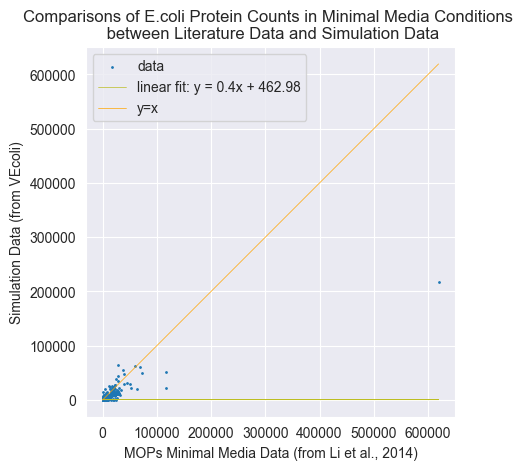

In [57]:
# Plot the minimal media comparison graph using matplotlib:
mm_xdata = np.array(mm_v_MOPS_data); mm_ydata = np.array(mm_sim_PC_data)
plt.scatter(mm_xdata, mm_ydata, s=1, label="data")

m, b = np.polyfit(mm_xdata, mm_ydata, 1)
mm_Y_data = int(m) * mm_xdata + b
mm_legend_str = "linear fit: y = "+ str(round(m, 2)) +"x + "+ str(round(b, 2))
plt.plot(mm_xdata, mm_Y_data, linewidth=.5, color='#bcbd22', label=mm_legend_str)

max_value = max(max(mm_xdata), max(mm_ydata))
x=y=[i for i in range(0,max_value)]
plt.plot(x, y, linewidth=.5, color="orange", label="y=x")

plt.axis('square')
plt.legend()
plt.xlabel("MOPs Minimal Media Data (from Li et al., 2014)")
plt.ylabel("Simulation Data (from VEcoli)")
plt.title("Comparisons of E.coli Protein Counts in Minimal Media Conditions \n between Literature Data and Simulation Data")

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


Text(0.5, 1.0, 'Comparisons of E.coli Protein Counts in Minmal Media \n from Literature Data and Simulation Data')

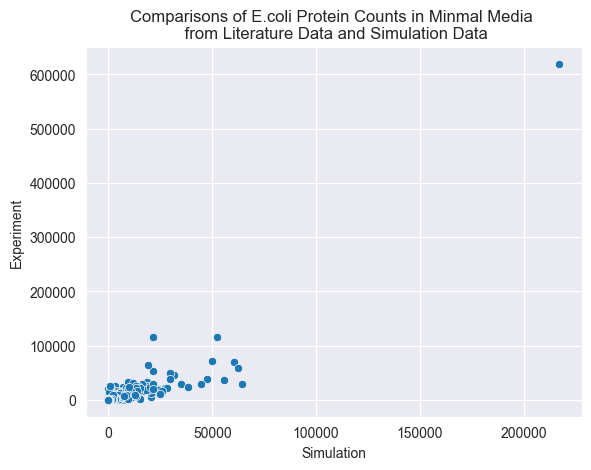

In [45]:
# Plot using the Polars dataframe method and Seaborn plotting method:
comparison_df = pl.DataFrame(np.array([mm_v_MOPS_data, mm_sim_PC_data]).T, schema=["Experiment", "Simulation"])

sns.scatterplot(x="Simulation", y="Experiment", data=comparison_df.to_pandas())
plt.title("Comparisons of E.coli Protein Counts in Minmal Media \n from Literature Data and Simulation Data")

## Comparison of rich media data from simulation results and Li et al., 2014

In [44]:
time = '1300'
date = '2024-04-23'
experiment = 'validation_experiment'
entry = f'{experiment}_{time}_{date}'
folder = f'out/cofactors/{entry}/'

In [20]:
output_all = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output_all['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pl.DataFrame(output['bulk'])

fluxes = np.array(fba['estimated_fluxes'][1:])
exchanges = fba['estimated_exchange_dmdt']

ans = output['listeners']['unique_molecule_counts']['active_ribosome']

In [21]:
# So say I want to find the names of the proteins themselves, these are functions to implement that do so: 
initial_state = json.load(open('data/wcecoli_t0.json'))

bulk_ids = [item[0] for item in initial_state['bulk']]

bulk.columns = bulk_ids

In [22]:
# take the protein [location] out of the name of the bulk ids: 
ecocyc_ids = []
for id in bulk_ids: 
	ecocyc_ids.append(id[0:-3])

ecocyc_id_idxs = []
for i in range(len(ecocyc_ids)):
	ecocyc_id_idxs.append(i)

In [23]:
# combine the protein counts for each monomer: 
id_idx_dict = {id: i for i, id in enumerate(bulk_ids)}
idx_id_dict = {idx: i for i, idx in id_idx_dict.items()}

protein_ids = complex_ids + monomer_ids
all_names = []
name_groups = []
idx_groups = []

for p in protein_ids:
	if p not in all_names:
		indexes = [name for key, name in id_idx_dict.items() if p in key]
		for idx in indexes:
			if ecocyc_ids[idx] == p:
				pass
			else:
				indexes.remove(idx)
		name_group = [idx_id_dict.get(name) for name in indexes]
		all_names.append(p)
		name_groups.append([name_group])
		idx_groups.append([indexes])

In [24]:
# fuse and collect protein counts of interest (in the C matrix): 
MM_bulk_interest_protein_counts = np.zeros([bulk.shape[0], len(protein_ids)])
MM_bulk_PC_dict = {}

for i in range(len(idx_groups)):
	id = protein_ids[i]
	idxs = idx_groups[i]
	if id in ecocyc_ids:
		if len(idxs) == 1:
			idx = idxs[0][0]
			df = np.array(bulk.select(bulk_ids[idx]))
		else:
			together = []
			for idx in idxs:
				index = idx[0]
				temp_df = np.array(bulk.select(bulk_ids[index]))
				together.append(temp_df)
			df = np.sum(together, axis=1)
		protein_counts = np.transpose(df)
		MM_bulk_interest_protein_counts[:, i] = protein_counts
		MM_bulk_PC_dict.update({id:idxs}) 

In [25]:
# Generate simulation data: 
MM_sim_protein_counts = MM_bulk_interest_protein_counts @ Cmatrix

# average the data across the timepoints accordingly: 
MM_avg_sim_data = MM_sim_protein_counts.mean(axis=0)

In [26]:
# Data from Ecocyc (https://ecocyc.org/groups?tab=SPECIAL&orgid=ECOLI): 
EC_proteins = ecocyc_data.Proteins
EC_genes = ecocyc_data.Genes
EC_gene_CNs = ecocyc_data['Common-Name']

# organize Ecocyc protein name and gene name data: 
EC_id_idx_dict = {id: i for i, id in enumerate(EC_proteins)}
EC_idx_id_dict = {idx: i for i, idx in EC_id_idx_dict.items()}

EC_Gene_idx_dict = {id: i for i, id in enumerate(EC_gene_CNs)}
EC_idx_Gene_dict = {idx: i for i, idx in EC_Gene_idx_dict.items()}

In [27]:
# find the gene name for each monomer in the bulk data using Ecocyc data: 
MM_BD_gene_ids = []
MM_monomers_not_in_EC = []
MM_monomer_idxs_in_EC = []
gene = 1
for i in range(len(monomer_ids)):
	if gene not in MM_BD_gene_ids: 
		monomer = monomer_ids[i]
		monomer_idx = [name for key, name in EC_id_idx_dict.items() if monomer in key]
		if len(monomer_idx) == 0:
			MM_monomers_not_in_EC.append(monomer)
		else: 
			monomer_idx = monomer_idx[0]
			gene = EC_idx_Gene_dict.get(monomer_idx)
			MM_BD_gene_ids.append([gene])
			MM_monomer_idxs_in_EC.append(i)
			
len(MM_BD_gene_ids)

4321

In [28]:
# validation data sets from Li et al., 2014 (https://www.sciencedirect.com/science/article/pii/S0092867414002323?via%3Dihub#app1):
validation_genes = validation_data.Gene
validation_MOPS_data = validation_data['MOPS complete']
validation_MOPS_min = validation_data['MOPS minimal']
validation_MOPS_wo_M = validation_data['MOPS complete without methionine']

# organize validation genes:
V_gene_idx_dict = {id: i for i, id in enumerate(validation_genes)}
V_idx_gene_dict = {idx: i for i, idx in V_gene_idx_dict.items()}

In [29]:
# Filter out less confident data from the validation data set: 
MM_V_data = []
MM_V_data_idxs = []
MM_V_data_unsure = []
for i in range(len(validation_MOPS_data)):
	PC = validation_MOPS_data[i]
	# if the data is not confident enough, indicated by brackets, then leave it out
	if type(PC) == str:
		PC = PC.replace("[",""); PC = PC.replace("]","")
		PC = int(PC)
		MM_V_data_unsure.append(PC)
	else:
		int(PC)
		MM_V_data.append(PC)
		MM_V_data_idxs.append(i)

len(MM_V_data)

# Extract the remaining gene names of the simulation data: 
MM_V_data_gene_ids = []
for i in range(len(MM_V_data)):
	idx = MM_V_data_idxs[i]
	gene_id = V_idx_gene_dict.get(idx)
	MM_V_data_gene_ids.append(gene_id)
	
len(MM_V_data_gene_ids)

# Reorganize the validation gene data set: 
MM_V_gene_idx_dict = {id: i for i, id in enumerate(MM_V_data_gene_ids)}
MM_V_idx_gene_dict = {idx: i for i, idx in MM_V_gene_idx_dict.items()}

In [30]:
# find matches between the simulation data and validation data: 
MM_matches = []
MM_V_match_idxs = []
MM_sim_match_idxs = []
MM_non_matches = []

G = 1
for i in range(len(MM_BD_gene_ids)):
	if G not in MM_matches: 
		G = (MM_BD_gene_ids[i])
		G = str(G[0])
		gene_idx = [name for key, name in MM_V_gene_idx_dict.items() if G in key]
		if len(gene_idx) == 0:
			MM_non_matches.append(G)
		else: 
			gene_idx = gene_idx[0]
			MM_V_match_idxs.append(gene_idx)
			gene = MM_V_idx_gene_dict.get(gene_idx)
			MM_matches.append([gene])
			MM_sim_match_idxs.append(i)
		
len(MM_matches)

2717

In [32]:
# Extract data columns from monomers not found in the Ecocyc data (corresponding to the names in MM_BD_gene_ids): 
MM_avg_sim_PCs = MM_avg_sim_data[MM_monomer_idxs_in_EC]

# Map the genes that do match together (corresponding to the names in matches): 
MM_avg_sim_PCs = np.transpose(MM_avg_sim_PCs)
MM_sim_PC_data = MM_avg_sim_PCs[MM_sim_match_idxs]

# obtain validation data that can be compared with simulation data
MM_v_MOPS_data = []
MM_v_MOPS_ids = []
for idx in MM_V_match_idxs: 
	gene_id = MM_V_data_gene_ids[idx]
	MM_v_MOPS_ids.append(gene_id)
	PC_data = MM_V_data[idx]
	MM_v_MOPS_data.append(PC_data)
	
len(MM_v_MOPS_data)

2717

Text(0.5, 1.0, 'Comparisons of Protein Counts for E.coli from Literature Data and Simulation Data')

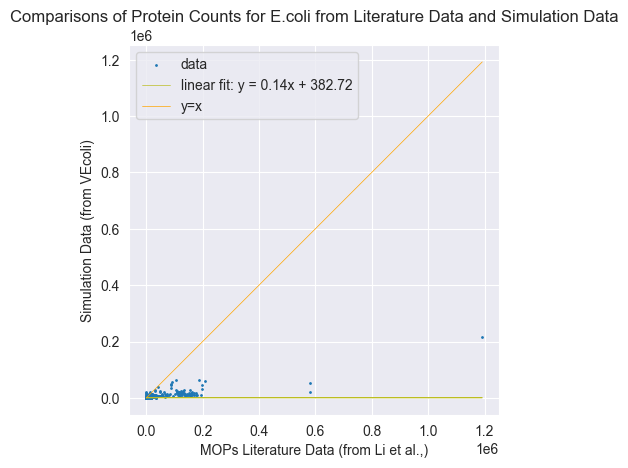

In [58]:
# Plot the comparison graph: 
MM_xdata = np.array(MM_v_MOPS_data); MM_ydata = np.array(MM_sim_PC_data)
plt.scatter(MM_xdata, MM_ydata, s=1, label="data")

m, b = np.polyfit(MM_xdata, MM_ydata, 1)
MM_Y_data = int(m) * MM_xdata + b
MM_legend_str = "linear fit: y = "+ str(round(m, 2)) +"x + "+ str(round(b, 2))
plt.plot(MM_xdata, MM_Y_data, linewidth=.5, color='#bcbd22', label=MM_legend_str)

max_value = max(max(MM_xdata), max(MM_ydata))
x=y=[i for i in range(0,max_value)]
plt.plot(x, y, linewidth=.5, color="orange", label="y=x")

plt.axis('square')
plt.legend()
plt.xlabel("MOPs Literature Data (from Li et al.,)")
plt.ylabel("Simulation Data (from VEcoli)")
plt.title("Comparisons of Protein Counts for E.coli from Literature Data and Simulation Data")

Text(0.5, 1.0, 'Comparisons of Protein Counts for E.coli from Literature Data and Simulation Data')

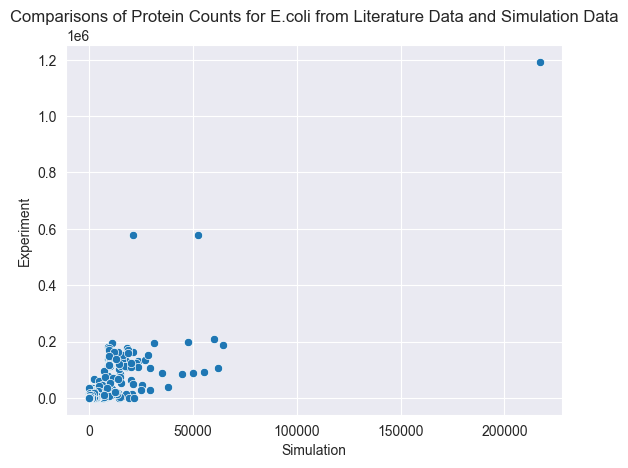

In [37]:
# Plot using the Polars dataframe method and Seaborn plotting method:
comparison_df = pl.DataFrame(np.array([MM_v_MOPS_data, MM_sim_PC_data]).T, schema=["Experiment", "Simulation"])

sns.scatterplot(x="Simulation", y="Experiment", data=comparison_df.to_pandas())
plt.title("Comparisons of Protein Counts for E.coli from Literature Data and Simulation Data")